# Sentence Embeddings on Arabic Song Lyric

In this work, I trained the Arabic Song Lyric sentence-level embeddings with the Fast Sentence Embedding (FSE) library by [Oliver Borchers](https://github.com/oborchers/Fast_Sentence_Embeddings/blob/master/README.md) using the [AraVec](https://github.com/bakrianoo/aravec/tree/master/AraVec%202.0) pre-trained embeddings built from this [Arabic Wikipedia dump](https://dumps.wikimedia.org/arwiki/latest/arwiki-latest-pages-articles.xml.bz2).

The code applied the Smooth Inverse Frequency (SIF) implementation described in the paper [*A Simple but Tough-To-Beat Baseline for Sentence Embeddings*](https://openreview.net/forum?id=SyK00v5xx).

This code depends on <code>fse</code>, <code>nltk</code>, and <code>gensim</code> to run. Details of how to download and install them will be on the links above. 

## Imports

In [221]:
# data preparation
from fse import SplitIndexedList

# for sentence embedding model training
from fse.models.average import FAST_VERSION, MAX_WORDS_IN_BATCH

# for Arabic sentence tokenisation
from nltk import sent_tokenize

# for loading word embeddings
from gensim.models import Word2Vec

# for sentence embedding with Smooth Inverse Frequency (SIF)
from fse.models import SIF

# for fun with scatter plots of similar lyrics
import matplotlib.pyplot as plt

## Loading dataset (i.e. song lyrics file)

In [37]:
# I have earlier extracted only the lyrics from the file
textfile = "/home/ignatius/Desktop/new_projects/Mo/sample_lyrics_only.csv"
def read_input(input_file):
    with open(input_file,'r',encoding='utf8') as f:
        for i, line in enumerate(f):
            if sent_tokenize(line):
                yield sent_tokenize(line)
sentences = []
for sents in read_input(textfile):
    sentences.extend(sents)
s = SplitIndexedList(sentences)

### Viewing file size and top lines

In [21]:
top = 3 #modify this value to see more or less...
print(len(s))
for i, sent in enumerate(s):
    if (i<top): print(sent)
    else: break

131
(['من', 'يوم', 'ماجيت', 'على', 'قلبى', 'ناديت', 'بهوالك', 'حسيت', 'فرحة', 'عينى'], 0)
(['دا', 'انا', 'روحى', 'معاك', 'قلبى', 'بيهواك', 'وبعيش', 'وياك', 'كل', 'سنينى'], 1)
(['والله', 'واحلوت', 'الايام', 'لما', 'حسيت', 'معاك', 'بغرام'], 2)


## Loading <code>AraVec</code> pre-trained embedding

In [30]:
# I downloaded and extracted it before this...
print("Be patient...this might take a while...", end="")
model_path = "/home/ignatius/Desktop/new_projects/Mo/AraSIF-master/models/full_grams_sg_300_wiki.mdl"
model = Word2Vec.load(model_path)
print("Model successfully loaded!")

Be patient...this might take a while...Model successfully loaded!


## Training sentence embedding

In [32]:
# Just to confirm that MAX_WORDS_IN_BATCH=1000; FAST_VERSION=1.
# Recommended values
print(f"MAX_WORDS_IN_BATCH = {MAX_WORDS_IN_BATCH}\nFAST_VERSION = {FAST_VERSION}")

MAX_WORDS_IN_BATCH = 10000
FAST_VERSION = 1


### Actual Training...
I think (please don't quote me :D) the returned tuple is the **number of sentences** (or lyric lines) and **vocabulary** of the lyric dataset i.e. number of the unique words that appeared in the dataset.

In [38]:
sent_model = SIF(model, workers=2)
sent_model.train(s)

(131, 486)

## Querying the sentence embedding
Some of the fun things you can do with the trained sentence embedding model.

### Check the embedding of a sentence
Remember a sentence here means a line of lyrics.

To do that, you can pass the original index number e.g. **<code>sent_model.sv[100]</code>** will show the embedding for the *100th* lyric line in the file i.e. 'حياة ان ايدينا يکون مشبوک مع بعض'

The dimension of the embedding is 300. In the example below, I rounded the embedding values to 5 decimal places and them displayed only the 50 values.

In [185]:
print(len(sent_model.sv[100])) #shows embedding dimension
sent_model.sv[100].round(5)[:50] # round to 5dp and show top 50 

300


array([ 0.04721, -0.10034,  0.1144 ,  0.04351, -0.01721,  0.01096,
       -0.0762 ,  0.07382, -0.00653,  0.01494,  0.04307, -0.01992,
       -0.00725, -0.15728,  0.08365,  0.02966,  0.03772, -0.01305,
        0.10484, -0.03358,  0.00907, -0.01134,  0.07196, -0.05996,
        0.02376,  0.06491, -0.08328, -0.01259,  0.04557,  0.03488,
       -0.1112 , -0.09199,  0.08961,  0.01582, -0.13587, -0.04426,
       -0.0537 ,  0.08918,  0.11185,  0.02721, -0.01495,  0.0381 ,
       -0.09987, -0.0154 , -0.00196,  0.05881, -0.00799, -0.01295,
       -0.07948, -0.01682], dtype=float32)

### Check `similarity` and `distance` between lyrics

In [198]:
lyric_a, lyric_b = 6, 5 #vary these values to test
print(f"lyric_a: {' '.join(s[lyric_a][0])}\nlyric_b: {' '.join(s[lyric_b][0])}")
print(f"Similarity: {sent_model.sv.similarity(lyric_a, lyric_b).round(3)}")
print(f"Distance: {sent_model.sv.distance(lyric_a, lyric_b).round(3)}")

lyric_a: كان ليا دا فين ياملينى حنين ياحبيب العين قول بصراحة
lyric_b: اعمل ايه قلبى فيك بيدوب دا مش مكتوب عليه اختار
Similarity: 0.1599999964237213
Distance: 0.84


### Check the most similar lyrics `by_word`

In [199]:
sent_model.sv.similar_by_word("عيني", wv=sent_model.wv, indexable=s.items)

[('ذكراهم متفاركـ عيني', 26, 0.5853458642959595),
 ('انا في الغرام قلبي من جرحو من قلبي و يا عيني على العاشقين',
  65,
  0.3093312382698059),
 ('و احلف بروح روحي هو و عيني و روحي', 68, 0.3081241250038147),
 ('و عيون حبيبي يا هوى علي مش راضين', 62, 0.18106195330619812),
 ('و اروح و اشكي لمين جرح الحبيب جرحين', 67, 0.16696017980575562),
 ('كان ليا دا فين ياملينى حنين ياحبيب العين قول بصراحة',
  6,
  0.15186548233032227),
 ('و روح و اشكي لمين جرح الحبيب جرحين', 72, 0.1416168063879013),
 ('بعيوني وقلبي مخليهم', 30, 0.13992837071418762),
 ('ارتاح وريح قلبك انا اكثر منك احبك', 16, 0.09806551784276962),
 ('يا دمعتي و جروحي قوليلو قلبك فين', 74, 0.09768706560134888)]

### Check the most similar lyrics `by_sentence`

In [200]:
sent_model.sv.similar_by_sentence("من يوم ماجيت على قلبى ناديت بهوالك حسيت فرحة عينى".split(), model=sent_model, indexable=s.items)

[('من يوم ماجيت على قلبى ناديت بهوالك حسيت فرحة عينى', 0, 1.0000001192092896),
 ('لو يوم عييني قالو جرحي بيحلالو بعشق عذابي معاه', 70, 0.42464742064476013),
 ('بگو دوست دارم بهم بگو', 114, 0.27726486325263977),
 ('عزيزم بگو چت شده و چرا فکرم رو مشغول کردي', 126, 0.24750155210494995),
 ('نار الفراق نارهم و يامين يصبربهم على كل دمعة عين', 66, 0.2425152063369751),
 ('ما ينسى ولا يخلف الأماني', 45, 0.21340115368366241),
 ('ستاره گفتم آره بگو دوست داري', 89, 0.17496389150619507),
 ('عن محبه طويلة بينا ... العمر ماعشنا خوفا', 57, 0.1707918792963028),
 ('و اروح و اشكي لمين جرح الحبيب جرحين', 67, 0.16695822775363922),
 ('(ايراني) زندگي تا دست به دست هميم', 99, 0.16644954681396484)]

### Scatterplot of similar lyrics

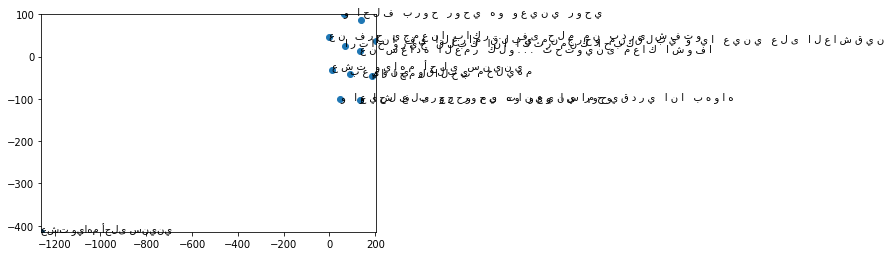

In [227]:
def show_closest_lyric_scatterplot(lyric_index):
    arr = np.empty((300), dtype='f')
    lyric, index = lyric_index
    labels = [" ".join(lyric)]
    
    # get close lyrics
    close_lyrics = sent_model.sv.similar_by_sentence(lyric, model=sent_model,indexable=s.items)
    
    # add the vector for each of the closest words to the array
    arr = np.vstack((arr, sent_model.sv[index]))
    
    for line, index,_ in close_lyrics:
        lyric_vector = sent_model.sv[index]
        labels.append(" ".join(line))
        arr = np.vstack((arr, np.array(lyric_vector)))
    
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=False)
    Y = tsne.fit_transform(np.nan_to_num(arr)) 
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)
    
    for label, x, y in zip(labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
show_closest_lyric_scatterplot(s[25]) #change value to alter plots

### Save embedding model for later
The full model can be saved as below:

In [229]:
sent_model.save('sent_full_model')

Or maybe as a text file as follows

In [241]:
def save_model_as_text_file(model, filename):
    with open(filename, 'w', encoding='utf8') as outputfile:
        for sent, i in s:
            sent = " ".join(sent)
            vecs = " ".join(str(v) for v in model.sv[i].round(4))
            outputfile.write(f"{sent} {vecs}\n")
save_model_as_text_file(sent_model,'sent_model.txt')

In [240]:
for sent, i in s:
    print(" ".join(sent))

من يوم ماجيت على قلبى ناديت بهوالك حسيت فرحة عينى
دا انا روحى معاك قلبى بيهواك وبعيش وياك كل سنينى
والله واحلوت الايام لما حسيت معاك بغرام
اد اما اقدر هكون وياك فى حضن هواك وان
لو تغيب عن عنيا احتار ببقى عايشة وكانى فى نار
اعمل ايه قلبى فيك بيدوب دا مش مكتوب عليه اختار
كان ليا دا فين ياملينى حنين ياحبيب العين قول بصراحة
ومسلمة ليك وبنادى عليك بطمن بيك ليك مرتاحة
انسى ولا تعذب قلبك صدقني الحب يتعبك
ما اريدك ياابن الناس ترجع مجروح احساس
تشكيلي الحب معذبك انسى ولا تعذب قلبك
الحب سهرني ليلي ما تدري سوه بحالي
كتلك منخوفي عليك ابعد الله يخليك
ليش تحب الميحبك انسى ولا تعذب قلبك
دمرت اعصابك اني وعرفت اشكد تهواني
لا تبجي ولا تنهار ولا تفكر بالي صار
ارتاح وريح قلبك انا اكثر منك احبك
أحبـــاب الروح
أحباب الروح جرحوني
راحوا لبعيد وخلوني
ظلموني ليش ظلموني
ومنهم ياليلحرموني
يا ليلي يا ليلييا ليلي يا ليلي
لومر الليل يواسيني
ويحاول بلكيينسيني
عشت وياهم أحلى سنيني
ذكراهم متفاركـ عيني
يا ليلي يا ليلييا ليلي يا ليلي
كل لحظه تمر بطاريهم
كذاب إلي كلكـناسيهم
بعيوني وقلبي مخليهم
دور بالروح تلكيهم
يا ليلي يال